# Weather in Tromsø over time

## Hypothesis

In this project we will look at the historical weather data gathered in Tromsø and see if the winters and summers have changed in the last years compared to earlier trends. We will look at snow-depth, temperature, precipitation and other factors if there has been a changing trend and if one can see the effects of climate change in Tromsø. 

## Requirements

In [59]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt 
import reading_data as rd



In [49]:
#Midlertidig løsning for å oppdatere reading_data
import importlib
importlib.reload(rd)


<module 'reading_data' from '/Users/tha222/git-folder/troms_weather/scripts/reading_data.py'>

In [30]:
client_id = '../ignore_me/client_id.txt'
client_secret = '../ignore_me/client_secret.txt'


## Finding the weather stations of Tromsø

Where are they and at what time did they collect data?

In [91]:
station_id = pd.read_csv('../data/station_names.csv', sep=';')
start_date, coor, names = [], [], []
station_id.drop(columns='location', inplace=True)
for station in station_id['stationId']:
    location = rd.ReadingData(station, client_id, client_secret)
    start, end, coordinates, name = location.get_station_info()
    start_date.append(start)
    coor.append(coordinates)
    names.append(name)


In [93]:
station_id['date'] = start_date
station_id['year'] = pd.to_datetime(station_id['date']).dt.strftime('%Y')
station_id['lon'] = [cor[0] for cor in coor]
station_id['lat'] = [cor[1] for cor in coor]
station_id['name'] = names
station_id.sort_values(by='date', inplace=True)


In [94]:
station_coordinates = gpd.GeoDataFrame(station_id, geometry=gpd.points_from_xy(station_id.lon, station_id.lat))
station_coordinates.crs = 'EPSG:4326'



In [95]:
station_coordinates 


,stationId,date,year,lon,lat,name,geometry
13,SN90450,1895-08-01,1895,18.93680,69.65370,Tromsø (Vervarslinga),POINT (18.9368 69.6537)
15,SN90490,1964-09-30,1964,18.91330,69.67670,Tromsø LH,POINT (18.9133 69.6767)
14,SN90400,1987-05-04,1987,18.90950,69.65380,Tromsø (Holt),POINT (18.9095 69.6538)
16,SN90491,1998-04-02,1998,18.78750,69.73330,Stor-Kjølen,POINT (18.7875 69.7333)
5,SN90720,2003-10-08,2003,18.69380,69.99030,Måsvik,POINT (18.6938 69.9903)
0,SN91020,2003-12-05,2003,19.51030,69.63670,Breivikeidet,POINT (19.5103 69.6367)
7,SN90980,2003-12-05,2003,19.66470,69.75650,Oldervik,POINT (19.6647 69.7565)
18,SN91080,2004-09-27,2004,19.71300,69.50000,Ytre Holmebukt,POINT (19.713 69.5)
10,SN91060,2009-01-15,2009,19.70920,69.60170,Sjursnes,POINT (19.7092 69.6017)
17,SN90451,2011-10-20,2011,18.93650,69.65370,Tromsø PLU,POINT (18.9365 69.6537)


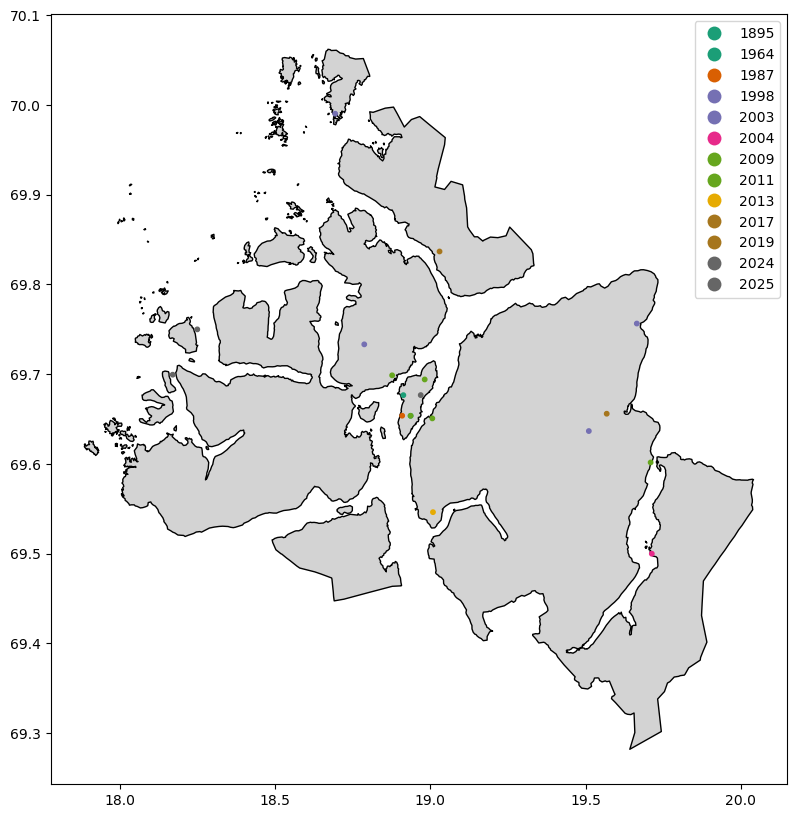

In [102]:
gdf = gpd.read_file('../test_files/Kommuner-L.geojson')
tromso = gdf[gdf['name'] == 'Tromsø']
fig, ax = plt.subplots(figsize=(10, 10))
tromso.plot(ax=ax, color="lightgrey", edgecolor="black")
station_coordinates.plot(ax=ax, column='year', cmap='Dark2', markersize=10, legend=True)
plt.show()


In [98]:
station_id


,stationId,date,year,lon,lat,name
13,SN90450,1895-08-01,1895,18.93680,69.65370,Tromsø (Vervarslinga)
15,SN90490,1964-09-30,1964,18.91330,69.67670,Tromsø LH
14,SN90400,1987-05-04,1987,18.90950,69.65380,Tromsø (Holt)
16,SN90491,1998-04-02,1998,18.78750,69.73330,Stor-Kjølen
5,SN90720,2003-10-08,2003,18.69380,69.99030,Måsvik
0,SN91020,2003-12-05,2003,19.51030,69.63670,Breivikeidet
7,SN90980,2003-12-05,2003,19.66470,69.75650,Oldervik
18,SN91080,2004-09-27,2004,19.71300,69.50000,Ytre Holmebukt
10,SN91060,2009-01-15,2009,19.70920,69.60170,Sjursnes
17,SN90451,2011-10-20,2011,18.93650,69.65370,Tromsø PLU


In [ ]:
station_name = 'SN90560'

kv_data = rd.ReadingData(station_name, client_id, client_secret)


In [21]:
kv_data.get_station_age()
df = kv_data.get_temperature_daily('2011-11-01','2025-02-28')


Success!
The station SN90560 has data from 2011-11-01 to Ongoing
Success!


In [62]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df_2012 = df[df['year'] == 2012].reset_index()
df_2024 = df[df['year'] == 2024].reset_index()


In [93]:
step = 20
overlap = 1

chart_2024 = alt.Chart(df_2024, height=step).transform_timeunit(
    Month='month(date)'
).transform_joinaggregate(
    mean_temp='mean(temperature)', groupby=['Month']
).transform_bin(
    ['bin_max', 'bin_min'], 'temperature'
).transform_aggregate(
    value='count()', groupby=['Month', 'mean_temp', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['Month', 'mean_temp'], key='bin_min', value=0
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('bin_min:Q')
        .bin('binned')
        .title('Maximum Daily Temperature (C)'),
    alt.Y('value:Q')
        .axis(None)
        .scale(range=[step, -step * overlap]),
    alt.Fill('mean_temp:Q')
        .legend(None)
        .scale(domain=[25, -15], scheme='redyellowblue')
).facet(
    row=alt.Row('Month:T')
        .title(None)
        .header(labelAngle=0, labelAlign='left', format='%B')
).properties(
    title='Tromsø 2024 Weather',
    bounds='flush'
)

chart_2012 = alt.Chart(df_2012, height=step).transform_timeunit(
    Month='month(date)'
).transform_joinaggregate(
    mean_temp='mean(temperature)', groupby=['Month']
).transform_bin(
    ['bin_max', 'bin_min'], 'temperature'
).transform_aggregate(
    value='count()', groupby=['Month', 'mean_temp', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['Month', 'mean_temp'], key='bin_min', value=0
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('bin_min:Q')
        .bin('binned')
        .title('Maximum Daily Temperature (C)'),
    alt.Y('value:Q')
        .axis(None)
        .scale(range=[step, -step * overlap]),
    alt.Fill('mean_temp:Q')
        .legend(None)
        .scale(domain=[25,-15], scheme='redyellowblue')
).facet(
    row=alt.Row('Month:T')
        .title(None)
        .header(labelAngle=0, labelAlign='left', format='%B')
).properties(
    title='Tromsø 2012 Weather',
    bounds='flush'
)


chart_2012 | chart_2024


alt.HConcatChart(...)

SyntaxError: invalid syntax (3868715299.py, line 1)